## A simple demostration of how to run

In [2]:
# before import, make sure FaceBoxes and Sim3DR are built successfully, e.g.,
# sh build.sh

import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.functions import draw_landmarks
from utils.render import render
from utils.depth import depth

import matplotlib.pyplot as plt

### Load configs

In [3]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX
    
    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    tddfa = TDDFA(gpu_mode=False, **cfg)
    face_boxes = FaceBoxes()

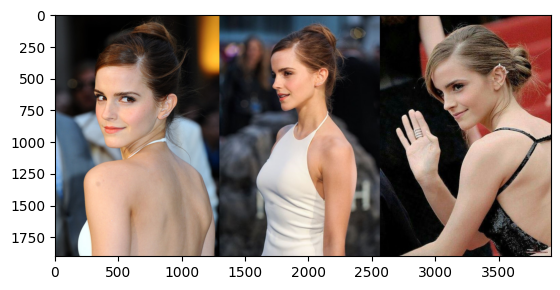

In [4]:
# given an image path
img_fp = 'examples/inputs/emma.jpg'
img = cv2.imread(img_fp)
plt.imshow(img[..., ::-1])
plt.show()

### Detect faces using FaceBoxes

In [5]:
# face detection
boxes = face_boxes(img)
print(f'Detect {len(boxes)} faces')
print(boxes)

Detect 3 faces
[[1699.8129, 278.49893, 2057.769, 762.4347, 0.9999492], [2999.3958, 304.86743, 3428.6719, 900.9679, 0.999895], [317.27078, 399.83633, 792.7348, 1048.3191, 0.99988747]]


### Regressing 3DMM parameters, reconstruction and visualization

In [6]:
# regress 3DMM params
param_lst, roi_box_lst = tddfa(img, boxes)

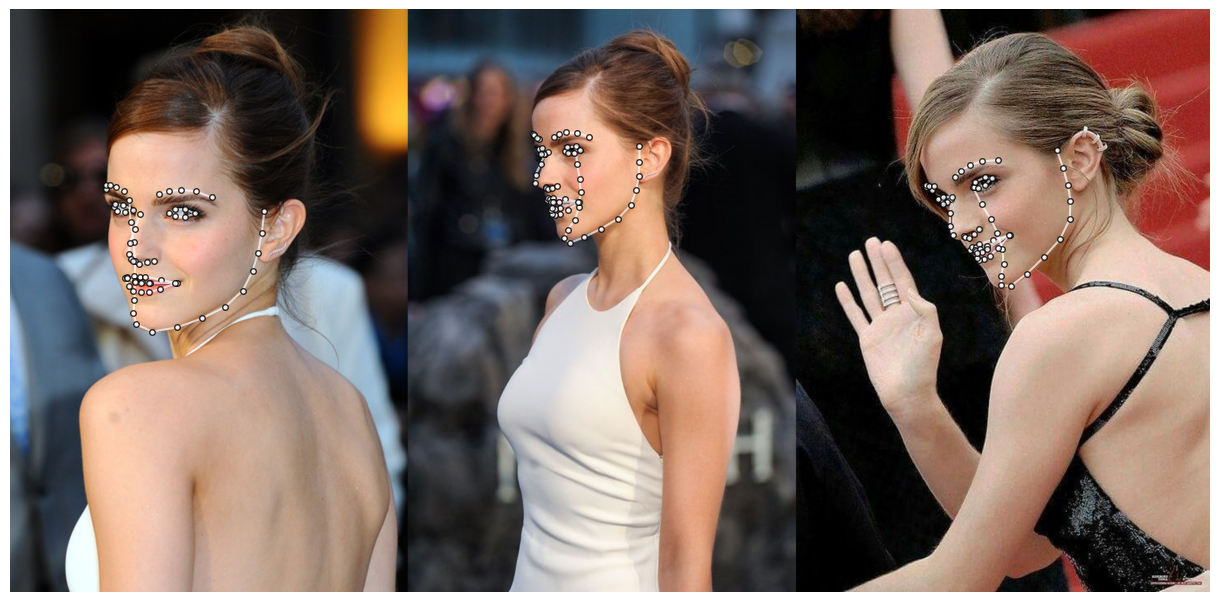

In [7]:
# reconstruct vertices and visualizing sparse landmarks
dense_flag = False
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

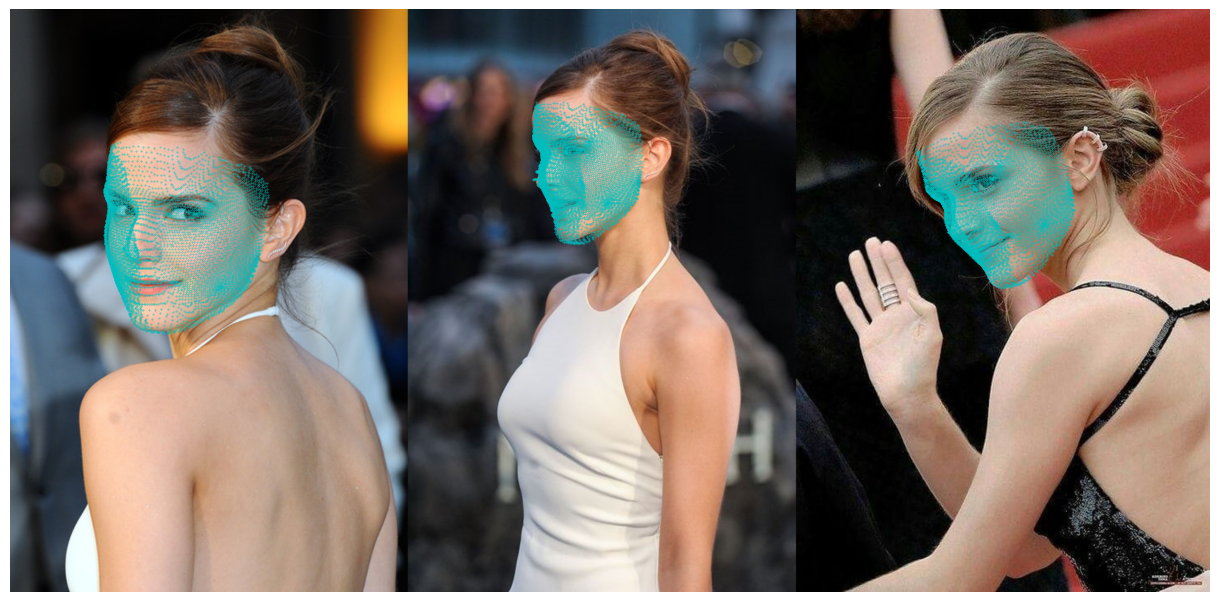

In [8]:
# reconstruct vertices and visualizing dense landmarks
dense_flag = True
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

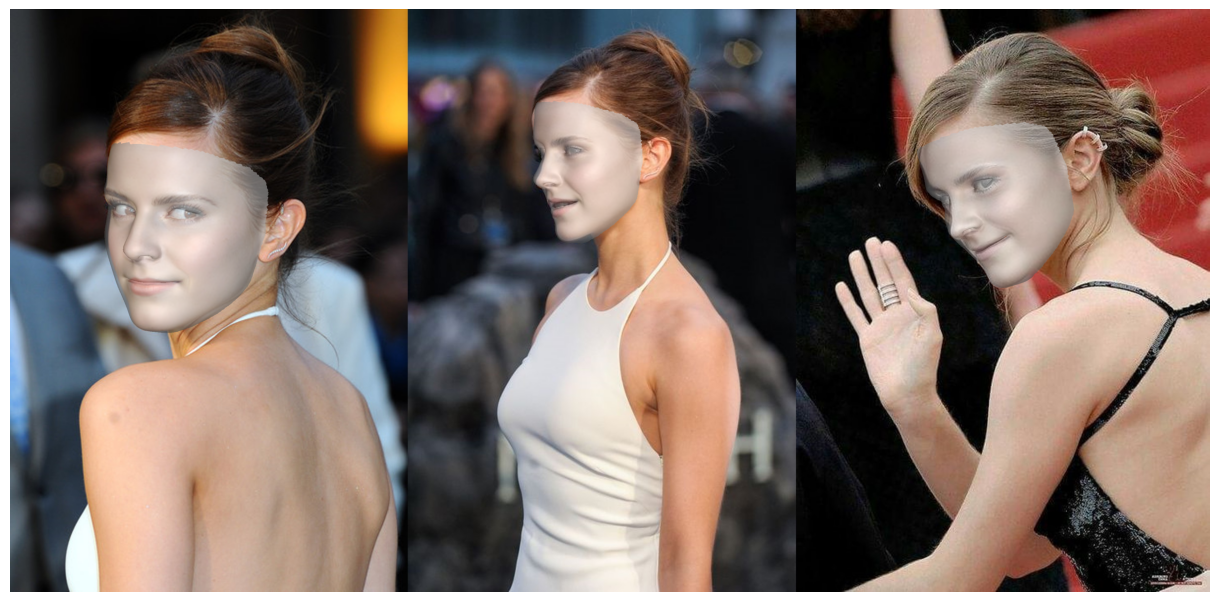

In [9]:
# reconstruct vertices and render
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
render(img, ver_lst, tddfa.tri, alpha=0.6, show_flag=True);

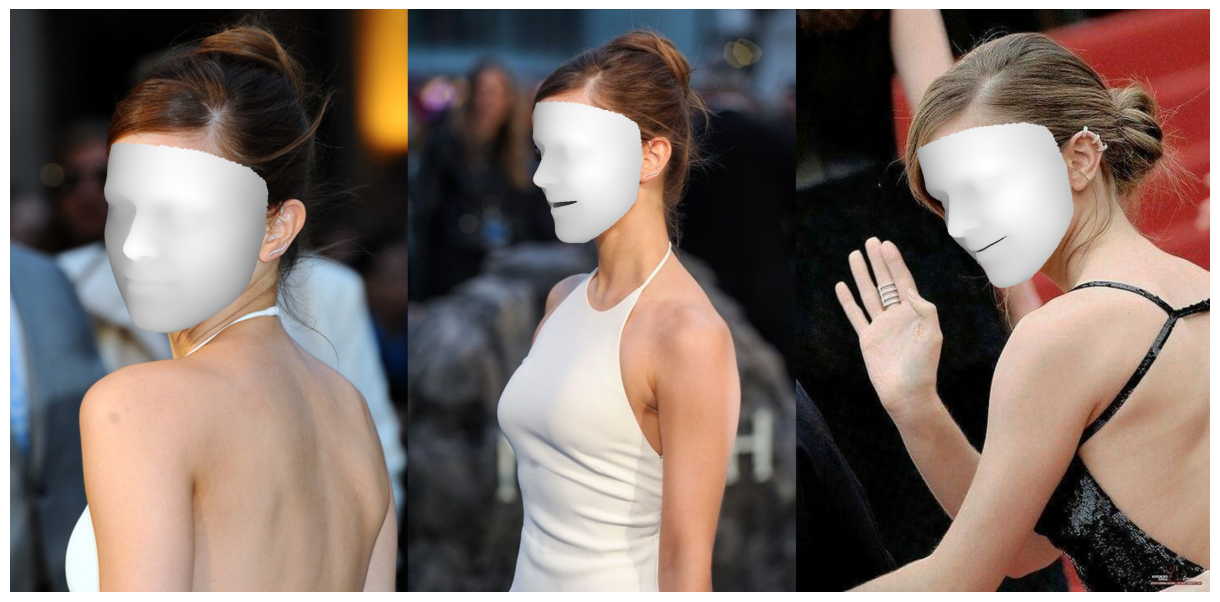

In [10]:
# reconstruct vertices and render depth
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
depth(img, ver_lst, tddfa.tri, show_flag=True);

yaw: 56.9, pitch: 7.9, roll: 2.0
yaw: 50.3, pitch: 6.0, roll: 24.4
yaw: 33.1, pitch: 12.0, roll: -4.8


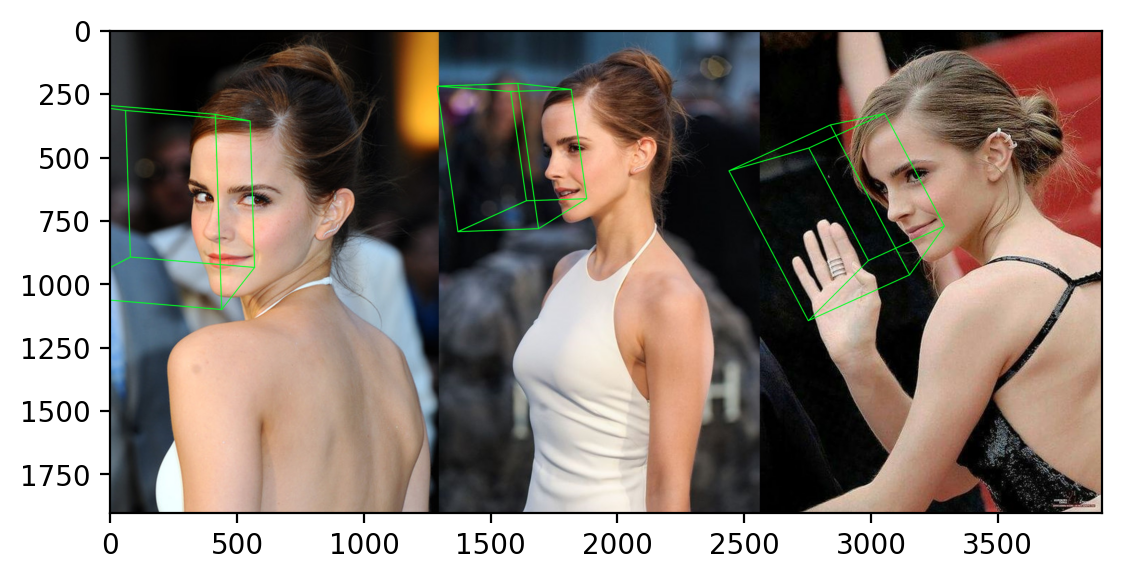

In [15]:
# Drawing box pose
from utils.pose import viz_pose
img = viz_pose(img, param_lst, ver_lst, tddfa.tri)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(dpi=200)
plt.imshow(img)
plt.show()